In [46]:
import pandas
import numpy as np

from clean import *

df_players_teams = pandas.read_csv("dataset/players_teams.csv")

df_players_teams = clean_teams_players(df_players_teams)

df_players_teams.head()

df_players= pandas.read_csv("dataset/players.csv")

df_players = clean_players(df_players)

df_merged = merge_player_info(df_players, df_players_teams) 

df_merged.head()



,playerID,year,stint,tmID,TotalGP,Points,TotalMinutes,TotaloRebounds,TotaldRebounds,TotalRebounds,...,TotalfgMade,TotalftAttempted,TotalftMade,TotalthreeAttempted,TotalthreeMade,TotalGS,TotalDQ,pos,height,weight
0,abrossv01w,2,0,MIN,26,343,846,43,131,174,...,114,132,96,76,19,23,2,F,74.0,169
1,abrossv01w,3,0,MIN,27,314,805,45,101,146,...,119,116,56,60,20,27,0,F,74.0,169
2,abrossv01w,4,0,MIN,33,341,861,45,101,146,...,118,106,77,89,28,28,0,F,74.0,169
3,abrossv01w,5,0,MIN,24,166,529,20,63,83,...,57,50,30,61,22,13,0,F,74.0,169
4,abrossv01w,6,0,MIN,31,304,777,29,78,107,...,109,73,53,82,33,31,0,F,74.0,169


c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


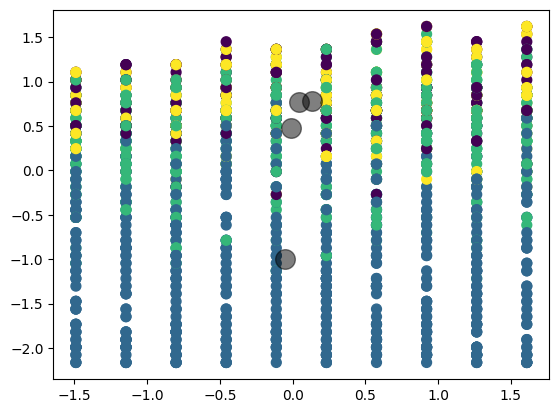

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# collumn tmID and stint should be dropped
df_players_teams = df_players_teams.drop(['tmID', 'stint'], axis=1)


X, Y = df_players_teams.iloc[:, 1:].values, df_players_teams.iloc[:, 0].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 4  # Number of clusters to create
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_

# graphic that shows the clusters
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()


In [48]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline

steps = [('scale', StandardScaler()),
         ('LOF', LocalOutlierFactor())
         ]

outliers = Pipeline(steps).fit_predict(X)

df_merged['outliers'] = outliers


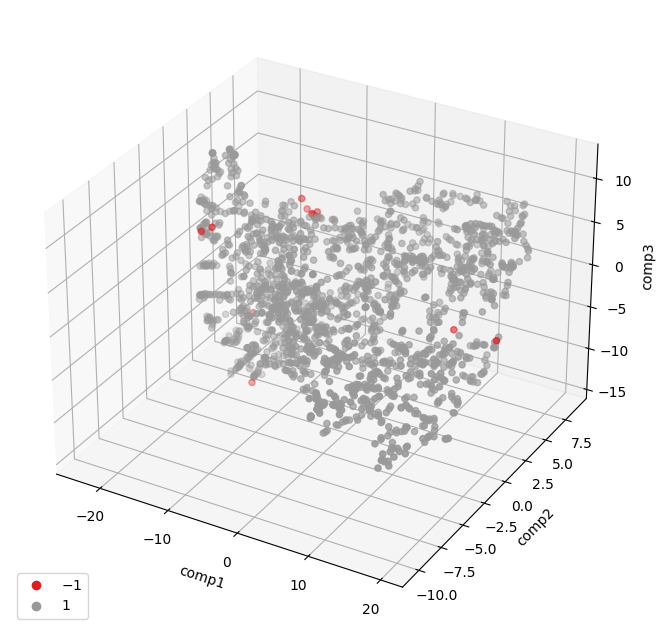

In [49]:
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE


tsne = TSNE(perplexity=25, n_components=3).fit_transform(X_scaled) # we need a good perplexity value to separate the groups
tsne = pandas.DataFrame(tsne, columns=['comp1', 'comp2', 'comp3'])
tsne['outliers'] = outliers

fig = plt.figure(figsize=(8, 8))  # create a new figure
ax = fig.add_subplot(111, projection='3d')  # create a 3D subplot
scatter = ax.scatter(tsne['comp1'], tsne['comp2'], tsne['comp3'],
                     c=tsne['outliers'], cmap='Set1')  # create 3D scatter plot
#
# add labels and legend
ax.set_xlabel('comp1')
ax.set_ylabel('comp2')
ax.set_zlabel('comp3')
plt.legend(*scatter.legend_elements(), loc='lower left')

plt.show()  # display the plot





In [51]:

df_best_and_worst = df_merged[df_merged['outliers'] == -1]
df_best_and_worst = df_best_and_worst.drop(['outliers'], axis=1)

# drop where stint != 0 ... as it skews the data
df_best_and_worst = df_best_and_worst[df_best_and_worst['stint'] == 0]

# show all uniques names
b_w_players = df_best_and_worst['playerID'].unique()

print(b_w_players)

['atkinla01w' 'catchta01w' 'chriska01w' 'clinest01w' 'coopecy01w'
 'crockwi01w' 'hornbal01w' 'payeka01w' 'scottol01w' 'stepama01w'
 'terryka01w' 'timmsmi01w' 'walkeay01w']


# TODO ... make this for every type of position / taking in case the defensive and ofensive statistics
